In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
import random
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error


# Wczytanie danych

In [22]:
allegro_df = pd.read_csv("https://www.dropbox.com/s/360xhh2d9lnaek3/allegro-api-transactions.csv?dl=1")

In [3]:
allegro_df.head()

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
0,0,2016-04-03 21:21:08,4753602474,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,59.99,1,997,0,50177,Warszawa,Komputery
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,Warszawa,"Odzież, Obuwie, Dodatki"
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.90,1,895,0,7389,Leszno,Dom i Ogród
3,3,2016-04-03 19:55:44,4783971474,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,18.50,0,971,0,15006,Wola Krzysztoporska,Książki i Komiksy
4,4,2016-04-03 18:05:54,4787908274,"['Odzież, Obuwie, Dodatki', 'Ślub i wesele', '...",1,1,PPHU_RICO,19.90,1,950,0,32975,BIAŁYSTOK,"Odzież, Obuwie, Dodatki"


In [4]:
allegro_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420020 entries, 0 to 420019
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lp                      420020 non-null  int64  
 1   date                    420020 non-null  object 
 2   item_id                 420020 non-null  int64  
 3   categories              420020 non-null  object 
 4   pay_option_on_delivery  420020 non-null  int64  
 5   pay_option_transfer     420020 non-null  int64  
 6   seller                  420020 non-null  object 
 7   price                   420020 non-null  float64
 8   it_is_allegro_standard  420020 non-null  int64  
 9   it_quantity             420020 non-null  int64  
 10  it_is_brand_zone        420020 non-null  int64  
 11  it_seller_rating        420020 non-null  int64  
 12  it_location             420020 non-null  object 
 13  main_category           420020 non-null  object 
dtypes: float64(1), int64

In [5]:
allegro_df[allegro_df['it_is_allegro_standard'] == 1].shape

(245063, 14)

# Pierwsza część

In [5]:
allegro_df['it_location'].value_counts()

Warszawa                23244
Kraków                  15135
Łódź                    10935
Poznań                  10610
Wrocław                  8646
                        ...  
wiechlice, szprotawa        1
Borzymie                    1
SĘKOWA                      1
puszczykowo                 1
Ruda slaska                 1
Name: it_location, Length: 10056, dtype: int64

In [10]:
#Target encoding
means = allegro_df.groupby('it_location')['price'].mean()
target_encoded = allegro_df.copy()
target_encoded['it_location'] = allegro_df['it_location'].map(means)
target_encoded.head()

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
0,0,2016-04-03 21:21:08,4753602474,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,59.99,1,997,0,50177,85.423398,Komputery
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,85.423398,"Odzież, Obuwie, Dodatki"
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.90,1,895,0,7389,61.990914,Dom i Ogród
3,3,2016-04-03 19:55:44,4783971474,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,18.50,0,971,0,15006,35.433365,Książki i Komiksy
4,4,2016-04-03 18:05:54,4787908274,"['Odzież, Obuwie, Dodatki', 'Ślub i wesele', '...",1,1,PPHU_RICO,19.90,1,950,0,32975,117.191956,"Odzież, Obuwie, Dodatki"


Jak widać przypisaliśmy średnie wartości kolumny target (dla nas price) do poszczególnych kategorii z it_location. Takie działanie może nam bardzo dopomóc w późniejszej fazie uczenia- modele lepiej bowiem radzą sobie z wartościami liczbowymi, a średnia powinna teoretycznie najpiej "umiejscawiać" kodowane kategorie w "świecie" naszych przewidywań.

One-hot encoding nienajlepiej sprawdza się w sytuacjach, gdy kodowanych kategorii jest bardzo dużo- tak jak w powyższej sytuacji (choć, oczywiście, można ich liczbę zredukować np. pomijając wielkość liter i polskie znaki w nazwach miejscowości oraz tworząc kategorię 'Other').

Należy też pamiętać, że średnia nie sprawdza się najlepiej, gdy mamy wiele wartości odstających, lub gdy po prostu wartości, z której jest ona liczona jest bardzo mało (w value counts powyżej widać, że jest bardzo dużo kategorii z pojedynczymi wystąpieniami- w ich przypadkach średnia może doprowadzać np. do przeuczenia.

In [11]:
allegro_df['main_category'].value_counts()

Dom i Ogród                            91042
Odzież, Obuwie, Dodatki                54257
Motoryzacja                            45941
Dla Dzieci                             42107
Uroda                                  28096
Sport i Turystyka                      27532
RTV i AGD                              20341
Telefony i Akcesoria                   19805
Komputery                              14491
Zdrowie                                13166
Książki i Komiksy                      11572
Delikatesy                              8074
Gry                                     7150
Rękodzieło                              6574
Kolekcje                                6146
Przemysł                                5959
Biżuteria i Zegarki                     5808
Biuro i Reklama                         3194
Fotografia                              2381
Muzyka                                  1961
Antyki i Sztuka                         1214
Konsole i automaty                      1053
Filmy     

In [23]:
#Wyodrebniam kolumne, którą bedziemy kodować
categories = allegro_df['main_category'].copy()
print(categories[:10])

0                  Komputery
1    Odzież, Obuwie, Dodatki
2                Dom i Ogród
3          Książki i Komiksy
4    Odzież, Obuwie, Dodatki
5    Odzież, Obuwie, Dodatki
6    Odzież, Obuwie, Dodatki
7        Biżuteria i Zegarki
8                  RTV i AGD
9                  RTV i AGD
Name: main_category, dtype: object


In [18]:
#One hot encoding
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder(sparse = False)
onehot_encoded = onehot.fit_transform(categories.to_numpy().reshape((len(categories),1)))
print(onehot_encoded[:10])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0.]]


In [24]:
#Label encoding
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
label_encoded = label.fit_transform(categories)
print(label_encoded[:10])

[12 18  6 14 18 18 18  3 20 20]


In [25]:
#Count encoding
import category_encoders as ce
count_encoder = ce.CountEncoder()
count_encoded = count_encoder.fit_transform(categories)
print(count_encoded[:10])

   main_category
0          14491
1          54257
2          91042
3          11572
4          54257
5          54257
6          54257
7           5808
8          20341
9          20341


### Wyjaśnienia:
Count Encoder- po prostu przypisuje każdej wartości w kolumnie liczbę jej wystąpień
Label Encoder- porządkuje wartości (alfabetycznie), a potem przypisuje kazdej numer
One Hot Encoder- tutaj przypisuje każdej wartości jej "kolumnę w tabeli" (reprezentowaną jako "1" na odpowiednim miejscu)

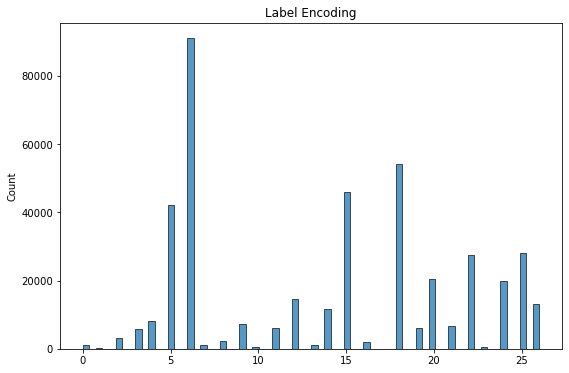

In [41]:
sns.histplot(label_encoded)
matplotlib.rcParams['figure.figsize'] = [9,6]
matplotlib.rcParams.update({'font.size': 10})
plt.title("Label Encoding")
plt.show()


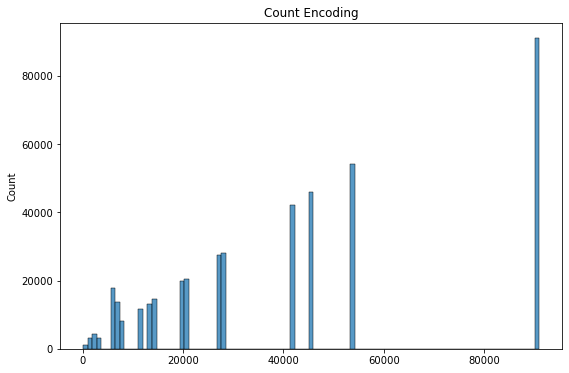

In [44]:
sns.histplot(count_encoded, legend = False)
matplotlib.rcParams['figure.figsize'] = [9,6]
matplotlib.rcParams.update({'font.size': 10})
plt.title("Count Encoding")
plt.show()
#Poza drobną anomalią- jest symetryczny

# Druga część

In [6]:
smaller_df = allegro_df.loc[range(0,10000),["price", "it_seller_rating", "it_quantity"]]

In [7]:
rmse_single_column = []
rmse_two_columns = []
inputer = KNNImputer(n_neighbors = 10, weights = "uniform")
length = smaller_df.shape[0]
first_test = smaller_df.copy()
second_test = smaller_df.copy()


In [8]:
for i in range(0,10):
  #Wprowadzam 3 różne zestawy indeksów
  random_indexes_1 = random.sample(range(0, length), length//10)
  random_indexes_2 = random.sample(range(0, length), length//10)
  random_indexes_3 = random.sample(range(0, length), length//10)
  #Po kolei zamieniamy wartości w poszczególnych kolumnach na wartości NaN
  first_test.loc[random_indexes_1,"it_seller_rating"] = np.nan
  second_test.loc[random_indexes_2,"it_seller_rating"] = np.nan
  second_test.loc[random_indexes_3,"it_quantity"] = np.nan
  #Ponownie uzupełniamy ramki, dla pewności zaokrąglamy też wyniki
  first_test = pd.DataFrame(data = inputer.fit_transform(first_test).round(), columns = ["price", "it_seller_rating", "it_quantity"]) 
  second_test = pd.DataFrame(data = inputer.fit_transform(second_test).round(), columns = ["price", "it_seller_rating", "it_quantity"]) 
  #Wyliczamy błędy średniokwadratowe poszczególnych ramek
  rmse_single_column.append(mean_squared_error(smaller_df, first_test))
  rmse_two_columns.append(mean_squared_error(smaller_df, second_test))
  #Przywracamy ramki do stanu pierwotnego dla kolejnej iteracji
  first_test = smaller_df.copy()
  second_test = smaller_df.copy()
  



In [9]:
print(rmse_single_column)
print(rmse_two_columns)

[36131726.31005501, 36213526.05508834, 38362479.618555, 34754199.53918834, 29297470.11875501, 39779803.54015501, 35515736.51538834, 42911954.830055006, 39637756.751821674, 39658547.502955005]
[45057442.458721675, 54918875.70332167, 59367641.143355004, 56733971.55282167, 54019775.388555, 54126756.10232168, 53687151.36228833, 49720001.501755, 57853487.47055501, 46935928.156355]


In [10]:
#Jak widać, błędy te są dość poważne- ponadto wzrastaja one w przypadku uzupełniania obydwu kolumn.

In [11]:
print(np.std(rmse_single_column))
print(np.std(rmse_two_columns))
#Podobnie jak odchylenie standardowe

3549596.6096784123
4410657.079942005


In [12]:
error_df = pd.DataFrame({'trial':range(0,10),'one_column':rmse_single_column, 'two_columns':rmse_two_columns})
melted_data = error_df.melt(id_vars = 'trial')


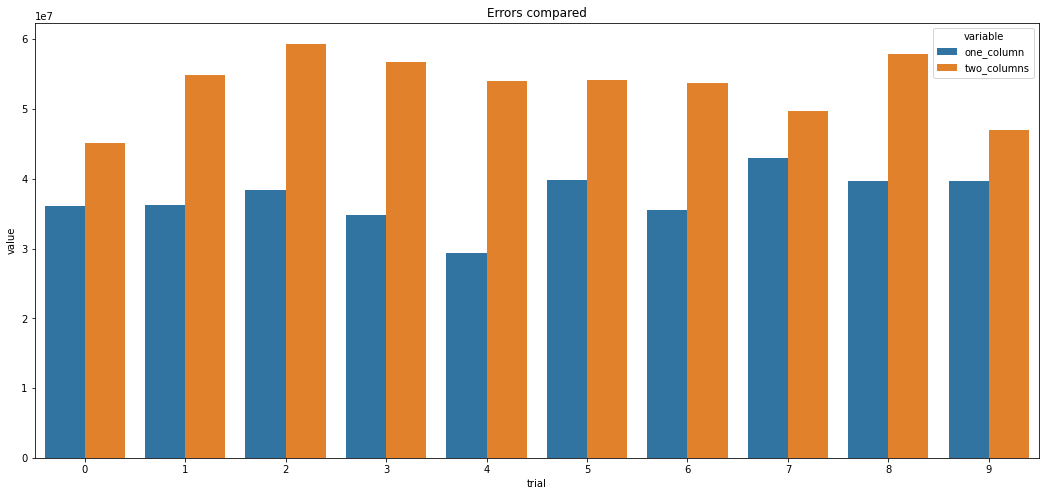

In [13]:
fig, ax = plt.subplots()
sns.barplot(x = 'trial', y = 'value', hue = 'variable', data = melted_data)
fig.set_size_inches(18,8)
plt.title("Errors compared")
plt.show()
matplotlib.rcParams.update({'font.size': 15})


### Wnioski
Jak widać, narzedzia do automatycznej imputacji brakujących wartości są dalekie od ideału. Można się było tego spodziewać- zadanie to nie należy do prostych. Przed podjęciem decyzji, co zrobić z brakującymi wartościami należy się więc zastanowić- czy wystarczy je usunąć? Czy jestem w stanie zastąpić je ręcznie? Jeśli nie, to który sposób imputacji wybrać? Od odpowiedzi na te pytania zależeć może m.in. wiarygodność wyników.